# Histogram Peaks To Locate Lane Lines

In [15]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

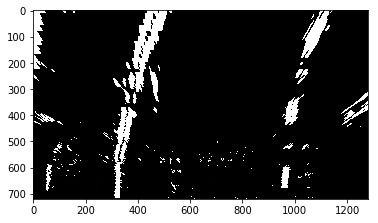

In [56]:
img = mpimg.imread('warped-example.jpg')
plt.imshow(img, cmap='gray')

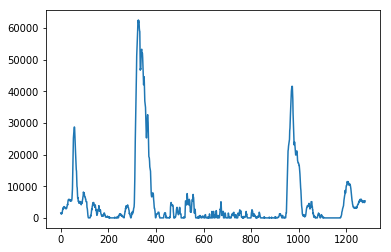

In [57]:
def hist(img):
    bottom_half = img[img.shape[0]//2:, :]
    
    # sum image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

histogram = hist(img)

plt.plot(histogram)

# Implement Sliding Windows and Fit a Polynomial

In [58]:
import cv2

40919 40919 21787 21787


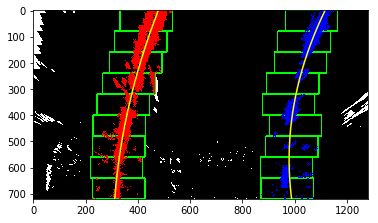

In [129]:
def find_lane_pixels(histogram, img):
    #create output img to draw on + visualize result
    out_img = np.dstack((img,img,img))
    
    # find 2 peaks on the halves of histogram
    midpt = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpt])
    rightx_base = np.argmax(histogram[midpt:]) + midpt
    
    # window HYPERPARAMS
    nwindows = 9
    margin = 100 # width of windows, +/- margin 
    minpix = 50 # min pixels found to recenter window
    
    # window height 
    win_height = np.int(out_img.shape[0]//nwindows)
    
    # x + y positions of nonzero pixels in image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # current pos to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # create empty lists for left + right lane pixel indices 
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # id window boundaries in x and y 
        win_y_low = img.shape[0] - (window+1)*win_height
        win_y_high = img.shape[0] - window*win_height
        
        # TODO: Find x boundaries for windows
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw windows 
        cv2.rectangle(out_img, 
                      (win_xleft_low, win_y_low), 
                      (win_xleft_high, win_y_high), (0,255,0), 3)
        
        cv2.rectangle(out_img, 
                      (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0,255,0), 3)
        
        good_left_inds = [i for i in range(len(nonzerox)) \
                          if nonzeroy[i] >= win_y_low and nonzeroy[i] <= win_y_high \
                          and nonzerox[i] >= win_xleft_low and nonzerox[i] <= win_xleft_high ]
        good_right_inds = [i for i in range(len(nonzerox)) \
                          if nonzeroy[i] >= win_y_low and nonzeroy[i] <= win_y_high \
                          and nonzerox[i] >= win_xright_low and nonzerox[i] <= win_xright_high ]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # TODO: found > minpix pixels, recenter next window 
        if len(good_left_inds) > minpix:
            leftx_current = np.mean([nonzerox[i] for i in good_left_inds]).astype(int)
        if len(good_right_inds) > minpix:
            rightx_current = np.mean([nonzerox[i] for i in good_right_inds]).astype(int)
            
    
    # concat arrays of good indices 
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    
    # extract left and right line pixel positions 
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

leftx, lefty, rightx, righty, out_img = find_lane_pixels(histogram, img)

def fit_poly(img_shape, leftx, lefty, rightx, righty):    
    # TODO: fit 2nd order poly using np.polyfit
    left_fit = np.polyfit(lefty, leftx, 2)
    print(len(leftx), len(lefty), len(rightx), len(righty))
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x + y values for plotting 
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + ploty
        right_fitx = 1*ploty**2 + ploty
 
    return left_fitx, right_fitx, ploty

    

left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
# Visualization 
out_img[lefty,leftx] = [255,0,0]
out_img[righty, rightx] = [0,0, 255]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(out_img)

# Search From Prior

## Skip the sliding windows step once you've found the lines


In [126]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

41638 41638 21444 21444
41638 41638 21444 21444


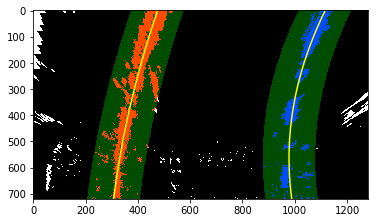

In [130]:
def search_around_poly(img):
    margin = 100 # hyperparameter
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    
    left_lane_inds = []
    right_lane_inds = [] 
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_lane_inds = [i for i in range(len(nonzerox)) \
                      if  nonzerox[i] >= left_fitx[nonzeroy[i]]-margin and 
                      nonzerox[i] <= left_fitx[nonzeroy[i]]+margin ]
    
    right_lane_inds = [i for i in range(len(nonzerox)) \
                      if  nonzerox[i] >= right_fitx[nonzeroy[i]]-margin and 
                      nonzerox[i] <= right_fitx[nonzeroy[i]]+margin ]
        
    # extract left and right line pixel positions 
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    print(len(leftx), len(lefty), len(rightx), len(righty))
    
    # fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
    
    # Visualization 
    out_img = np.dstack((img,img,img))
    window_img = np.zeros_like(out_img)
    
    # color in line pixels
    out_img[lefty,leftx] = [255,0,0]
    out_img[righty, rightx] = [0,0, 255]
    
    # generate polygon to show search window area
    # recast x + y points for cv2.fillPoly()
    left_line_window1 = np.array([ np.transpose( np.vstack([left_fitx-margin, ploty]) ) ])
    left_line_window2 = np.array([ np.flipud( np.transpose( np.vstack([left_fitx+margin, ploty]) ) ) ])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([ np.transpose( np.vstack([right_fitx-margin, ploty]) ) ])
    right_line_window2 = np.array([ np.flipud( np.transpose( np.vstack([right_fitx+margin, ploty]) ) ) ])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # draw lane 
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
    result = cv2.addWeighted(out_img, 1, window_img, .3, 0)
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return result

result = search_around_poly(img)
plt.imshow(result)

# Fitting on Large Curves
One thing to consider in our current implementation of sliding window search is what happens when we arrive at the left or right edge of an image, such as when there is a large curve on the road ahead. If `minpix` is not achieved (i.e. the curve ran off the image), the starting position of our next window doesn't change, so it is just positioned directly above the previous window. This will repeat for however many windows are left in `nwindows`, stacking the sliding windows vertically against the side of the image, and likely leading to an imperfect polynomial fit.

Can you think of a way to solve this issue? If you want to tackle the curves on the harder challenge video as part of the project, you might want to include this in your lane finding algorithm.